# Dog Breed Identification : Modèle AlexNet

Nous allons utiliser le modèle `AlexNet` sur des données importées avec le module `data_prep` en ajustant quelques hyper-paramètres.

## Préparation de l'environnement du travail

### Importation des packages

In [23]:
from data_prep import load_data
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import pickle

Regardons combien de GPUs disponible (que nous pouvons utiliser)

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Dézipper le fichier de données

In [3]:
zip_ref = zipfile.ZipFile("dog-breed-identification.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

### Récupération des données

Les données sont en deux parties: 
1. Le ficher `labels.csv` qui contient les `id` des images (le nom de fichier image sans extension) liés à leur modalité `breed`.
2. Le dossier `train` avec les images en format jpg.

Commençant par ajouter l'extension `.jpg` aux id des images dans `labels.csv` pour faciliter les tâches par la suite.

In [4]:
def append_ext(fn):
  return fn+".jpg"

In [5]:
df_train = pd.read_csv("/tmp/labels.csv")
df_train['id'] = df_train['id'].apply(append_ext)
df_train = df_train.set_index('id')
labelNames = df_train["breed"].unique()
labelNames.shape

(120,)

Nous avons 120 types de chiens (120 modalités), et 10222 images dans le dossier train.

In [6]:
df_train.head()

breed
id                                                    
000bec180eb18c7604dcecc8fe0dba07.jpg       boston_bull
001513dfcb2ffafc82cccf4d8bbaba97.jpg             dingo
001cdf01b096e06d78e9e5112d419397.jpg          pekinese
00214f311d5d2247d5dfe4fe24b2303d.jpg          bluetick
0021f9ceb3235effd7fcde7f7538ed62.jpg  golden_retriever

Ensuite, nous allons encoder ces modalités grâce à `LabelEncoder` pour avoir des nombres au lieu des chaînes de caractères :

In [7]:
le = LabelEncoder()
le.fit(df_train['breed'])
df_train['y'] = le.transform(df_train['breed'])

## Création du modèle (train/dev/test)

Avant de passer à l'entraînement, nous allons formatez les images en `tensors` à virgule flottante en les prétraitant de la manière suivante :

1.   Lire les images du disque.
2.   Décoder le contenu de ces images et le convertir au format de grille approprié selon leur contenu RGB.
3.   Convertir les en `tensors` à virgule flottante des valeurs entre 0 et 255 à des valeurs comprises entre 0 et 1.
4.   Redimensionnez les images.

Le module `data_prep` créé dans le cadre de ce projet, contient la fonction pour `load_data` qui permet d'avoir les images en format souhaité.

In [8]:
PATH = "/tmp/"
IMG_SIZE = 227
trainX,testX,trainY,testY = load_data(df_train,PATH,IMG_SIZE=IMG_SIZE,flip=True)

La taille des images est fixé à 227 et le paramètre `flip` de `load_data` permet de augmenter la taille de jeu de données en ajoutant des nouveux images avec un enversement horizontal des anciens.

In [9]:
trainX.shape

(13629, 227, 227, 3)

In [10]:
testX.shape

(6815, 227, 227, 3)

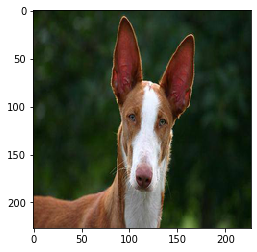

In [11]:
plt.imshow(trainX[5121])

### Hyper-paramètres

Fixant quelques hyper-paramètres et les variables qui seront utilisés pour l'entraînement :

In [12]:
batch_size = 128
epochs = 20
learning_rate = 0.001
m = trainX.shape[0]
input_shape = (IMG_SIZE, IMG_SIZE, trainX.shape[-1])
num_classes = labelNames.shape[0]

Nous n'allons pas pouvoir malheuresement normaliser les données, car nous ne poussédons pas du matériel pour le type `float32`.

In [13]:
# scale data to the range of [0, 1]
#trainX = trainX.astype("float32") / 255.0
#testX = testX.astype("float32") / 255.0
#trainX = trainX.astype("float16") / 255.0
#testX = testX.astype("float16") / 255.0

### Création du réseau de neurones `AlexNet`

In [14]:
tf.keras.backend.clear_session()

model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding="valid", activation = "relu"))

# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="valid"))

# Normalization
model.add(BatchNormalization())

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding="same", activation = "relu"))

# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="valid"))

# Normalization
model.add(BatchNormalization())

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"))

# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding="valid"))

# Normalization
model.add(BatchNormalization())

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(units = 9216, activation = "relu"))

# 2nd Fully Connected Layer
model.add(Dense(units = 4096, activation = "relu"))

# 3rd Fully Connected Layer
model.add(Dense(4096, activation = "relu"))

# Output Layer
model.add(Dense(120, activation = "softmax"))


model.summary()

W0216 21:47:01.190175 140248194664256 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       8

Choisissons `accuracy` comme metrique et `Adam` comme optimisateur, avec learning_rate = 0.001 : 

In [15]:
opt = Adam(lr=learning_rate)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Entraînement du modèle : 

In [16]:
history = model.fit(trainX, trainY, batch_size = batch_size, epochs = epochs, verbose=1,validation_split=0.10)

Train on 12266 samples, validate on 1363 samples
Epoch 1/20
12266/12266 [==============================] - 41s 3ms/sample - loss: 5.3799 - acc: 0.0227 - val_loss: 9.6381 - val_acc: 0.0147
Epoch 2/20
12266/12266 [==============================] - 35s 3ms/sample - loss: 4.4340 - acc: 0.0418 - val_loss: 4.6260 - val_acc: 0.0264
Epoch 3/20
12266/12266 [==============================] - 35s 3ms/sample - loss: 4.2652 - acc: 0.0523 - val_loss: 4.9258 - val_acc: 0.0293
Epoch 4/20
12266/12266 [==============================] - 35s 3ms/sample - loss: 4.0718 - acc: 0.0752 - val_loss: 4.8440 - val_acc: 0.0360
Epoch 5/20
12266/12266 [==============================] - 35s 3ms/sample - loss: 3.8494 - acc: 0.1043 - val_loss: 4.5769 - val_acc: 0.0411
Epoch 6/20
12266/12266 [==============================] - 35s 3ms/sample - loss: 3.5559 - acc: 0.1486 - val_loss: 4.3678 - val_acc: 0.0800
Epoch 7/20
12266/12266 [==============================] - 35s 3ms/sample - loss: 3.1192 - acc: 0.2187 - val_loss: 5.8

In [25]:
model.save("models/AlexNet/modelAlexNet1.h5")
with open('models/AlexNet/modelAlexNet1HistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

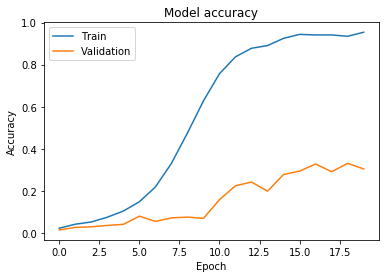

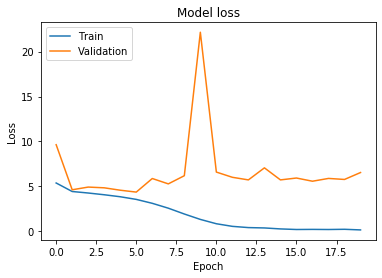

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
loss, acc = model.evaluate(trainX, trainY)
print(acc * 100)

13629/13629 [==============================] - 16s 1ms/sample - loss: 1.2118 - acc: 0.7855
78.55308651924133


In [28]:
loss, acc = model.evaluate(testX, testY)
print(acc * 100)

6815/6815 [==============================] - 8s 1ms/sample - loss: 6.7411 - acc: 0.2932
29.31768298149109
